# Graph Dataset Analysis


In [42]:
import glob
import torch
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
dataset_path = "../data/train_data_20.pt"
dataset = torch.load(dataset_path)

In [16]:
def add_project_root(relative_to=".."):
    import os, sys
    project_root = os.path.abspath(os.path.join(os.getcwd(), relative_to))
    if project_root not in sys.path:
        sys.path.insert(0, project_root)

## Compute stats per graph

In [17]:
add_project_root(relative_to="..")
from graph.data_builder import DataConverter

In [ ]:
node_types = {v: k for k, v in DataConverter.NODE_TYPES.items()}
directions       = {v: k for k, v in DataConverter.DIRECTIONS.items()}

records = []

for idx, (data, nest_id, food_id) in enumerate(dataset):
    x_np       = data.x.argmax(dim=1).numpy()
    edge_idx   = data.edge_index.numpy()
    edge_attr  = data.edge_attr.numpy()

    G = nx.DiGraph()
    
    # add nodes with the correct node_type
    for node_id, t_idx in enumerate(x_np):
        G.add_node(node_id, node_type=node_types[int(t_idx)])
    
    # add edges with distance & direction attrs
    for e in range(edge_idx.shape[1]):
        u, v = int(edge_idx[0, e]), int(edge_idx[1, e])
        dist, dir_idx = float(edge_attr[e, 0]), int(edge_attr[e, 1])
        G.add_edge(u, v,
                   distance=dist,
                   direction=directions[dir_idx])
    
    # get shortest‐path in terms of num of hops (edges)
    path_hops = nx.shortest_path(G, source=food_id, target=nest_id)
    d_fn_hops = len(path_hops) - 1
    # the sum of Euclidean distances along the shortest-distance path
    d_fn_distance = nx.shortest_path_length(
        G, source=food_id, target=nest_id, weight='distance'
    )

    # count distractors on the path between nest and food node
    num_distractors_on_path = sum(
        1 for v in path_hops[1:-1]
        if G.nodes[v]['node_type'] == 'distractor'
    )

    records.append({
        'sample':      idx,
        'd_fn_hops':   d_fn_hops,
        'd_fn_distance':   d_fn_distance,
        'num_distractors_on_path': num_distractors_on_path,
        'num_nodes':   G.number_of_nodes(),
        'num_edges':   G.number_of_edges(),
        'density':     nx.density(G.to_undirected()),
        'diameter':    nx.diameter(G.to_undirected()),
    })

df = pd.DataFrame(records)
print(df[['d_fn_hops','num_distractors_on_path','d_fn_distance']].describe())
df.head()

        d_fn_hops  num_distractors_on_path  d_fn_distance
count  400.000000               400.000000     400.000000
mean     2.155000                 1.155000      85.569572
std      0.382545                 0.382545      29.859218
min      2.000000                 1.000000      21.189679
25%      2.000000                 1.000000      63.511137
50%      2.000000                 1.000000      83.364459
75%      2.000000                 1.000000     102.874583
max      4.000000                 3.000000     200.999270


,sample,d_fn_hops,d_fn_distance,num_distractors_on_path,num_nodes,num_edges,density,diameter
0,0,2,41.345777,1,20,108,0.284211,4
1,1,2,109.015150,1,20,108,0.284211,4
2,2,2,89.183262,1,20,112,0.294737,4
3,3,2,52.098239,1,20,112,0.294737,3
4,4,2,96.269737,1,20,106,0.278947,4


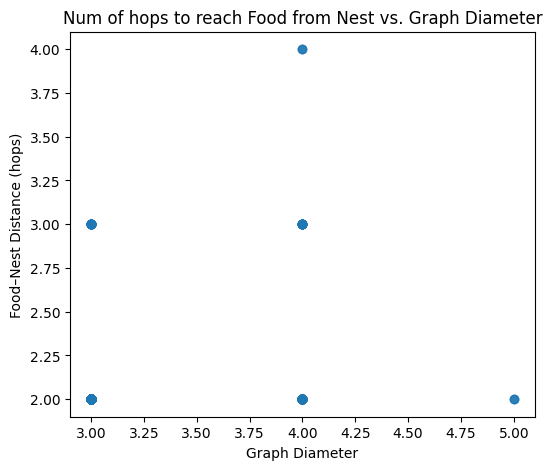

In [ ]:
['d_fn_hops', 'diameter']
plt.figure(figsize=(6, 5))
plt.scatter(df['diameter'], df['d_fn_hops'], alpha=0.6)
# diameter is to know how far apart can two nodes be in the graph
plt.xlabel('Graph Diameter')
plt.ylabel('Food–Nest Distance (hops)')
plt.title('Num of hops to reach Food from Nest vs. Graph Diameter')
plt.show()
# each dot is a graph

count    400.000000
mean       0.662583
std        0.137594
min        0.400000
25%        0.666667
50%        0.666667
75%        0.666667
max        1.000000
Name: d_ratio, dtype: float64


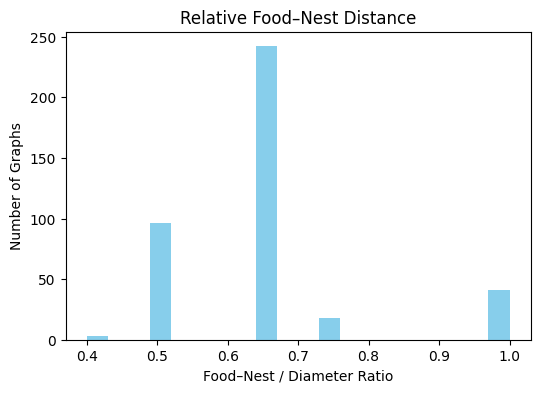

In [28]:
df['d_ratio'] = df['d_fn_hops'] / df['diameter']

print(df['d_ratio'].describe())

plt.figure(figsize=(6,4))
plt.hist(df['d_ratio'], bins=20, color='skyblue')
plt.xlabel('Food–Nest / Diameter Ratio')
plt.ylabel('Number of Graphs')
plt.title('Relative Food–Nest Distance')
plt.show()


## How increasing total num of nodes affect the complexity

In [34]:
node_types = {v: k for k, v in DataConverter.NODE_TYPES.items()}

def analyze_file(dataset_path):
    N = int(dataset_path.rstrip('.pt').split('_')[-1])
    dataset = torch.load(dataset_path)
    
    rows = []
    for data, nest_id, food_id in dataset:
        G = nx.DiGraph()
        x = data.x.argmax(dim=1).numpy()
        ei = data.edge_index.numpy()
        ea = data.edge_attr.numpy()

        # nodes
        for i, t in enumerate(x):
            G.add_node(i, node_type=node_types[int(t)])
            
        # edges
        for e in range(ei.shape[1]):
            u,v = int(ei[0,e]), int(ei[1,e])
            dist, _ = ea[e]
            G.add_edge(u,v, distance=float(dist))
        
        path_hops = nx.shortest_path(G, source=food_id, target=nest_id)
        d_hops = len(path_hops)-1
        d_dist = nx.shortest_path_length(G,
                                         source=food_id,
                                         target=nest_id,
                                         weight='distance')
        n_d = d_hops - 1
        
        diameter = nx.diameter(G.to_undirected())
        ratio = d_hops / diameter
        
        rows.append({
            'num_nodes': N,
            'd_fn_hops': d_hops,
            'd_fn_distance': d_dist,
            'n_distractors_on_path': n_d,
            'ratio': ratio
        })
    return pd.DataFrame(rows)


In [35]:
all_dfs = []
for path in glob.glob('../data/train_data_*.pt'):
    dfN = analyze_file(path)
    all_dfs.append(dfN)
df = pd.concat(all_dfs, ignore_index=True)

summary = df.groupby('num_nodes').agg({
    'd_fn_hops':   ['mean','std'],
    'n_distractors_on_path':['mean','std'],
    'd_fn_distance':  ['mean','std'],
    'ratio':      ['mean','std']
}).reset_index()
summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
summary

,num_nodes,d_fn_hops_mean,d_fn_hops_std,n_distractors_on_path_mean,n_distractors_on_path_std,d_fn_distance_mean,d_fn_distance_std,ratio_mean,ratio_std
0,2,1.000,0.000000,0.000,0.000000,51.769284,25.315003,1.000000,0.000000
1,5,2.365,0.589614,1.365,0.589614,120.509465,53.462026,0.771875,0.183062
2,10,2.500,0.822613,1.500,0.822613,118.261162,52.320540,0.642423,0.176226
3,20,2.155,0.382545,1.155,0.382545,85.569572,29.859218,0.662583,0.137594
4,50,2.015,0.121705,1.015,0.121705,64.967063,21.153229,0.672500,0.043763


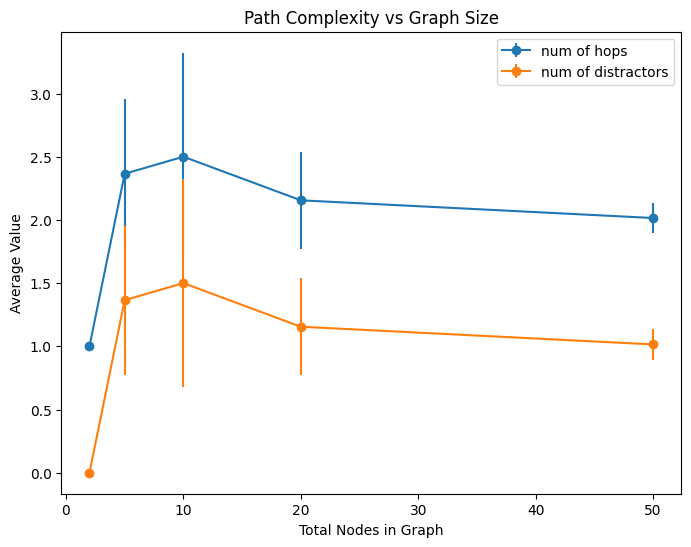

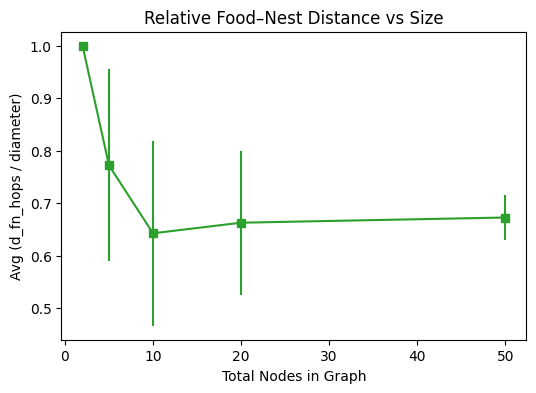

In [41]:
plt.figure(figsize=(8,6))
plt.errorbar(summary['num_nodes'],
             summary['d_fn_hops_mean'],
             yerr=summary['d_fn_hops_std'],
             marker='o', label='num of hops')
plt.errorbar(summary['num_nodes'],
             summary['n_distractors_on_path_mean'],
             yerr=summary['n_distractors_on_path_std'],
             marker='o', label='num of distractors')
plt.xlabel('Total Nodes in Graph')
plt.ylabel('Average Value')
plt.title('Path Complexity vs Graph Size')
plt.legend()
plt.show()

# relative ratio
plt.figure(figsize=(6,4))
plt.errorbar(summary['num_nodes'],
             summary['ratio_mean'],
             yerr=summary['ratio_std'],
             marker='s', color='C2')
plt.xlabel('Total Nodes in Graph')
plt.ylabel('Avg (d_fn_hops / diameter)')
plt.title('Relative Food–Nest Distance vs Size')
plt.show()


Based on the plot, the graph varies a lot from one another, which is good because then the agent train on both trivial and challenging cases in one go. Although, with increasing total num of nodes it becomes less varied and less complex, which could be attributed to the fact we only have 3 node types where food and nest node always only 1, so it is hard to have more variation because the rest will always be distractors.